In [1]:

"""
Figures for results of rooftop mapping in Washington D.C.

Figure 1. Study Area Map

Figure 2. ...

Figure 3. ...

Figure 4. ...

Figure 5. ...

Figure 6. ...


"""

import os
import geopandas as gpd
import rioxarray as rxr
import earthpy.plot as ep
from matplotlib import pyplot as plt

%matplotlib inline

print(os.getcwd())

projdir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-urban-fuels/rooftop-materials/'

# Coordinate Ref. System
proj = 32618  # UTM Zone 18N

print("Ready!")


/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-urban-fuels/rooftop-materials/code
Ready!


## Fig. 1: Study area map

Shape: (8, 7555, 6046); 
GeoTransform: 316269.0 3.0 0.0 4318296.0 0.0 -3.0; 
WKT: EPSG:32618; 
NoData Value: nan; 
Bands: <xarray.DataArray 'band' (band: 8)> Size: 64B
array([1, 2, 3, 4, 5, 6, 7, 8])
Coordinates:
  * band         (band) int64 64B 1 2 3 4 5 6 7 8
    spatial_ref  int64 8B 0; 
Band Names: ('coastal_blue', 'blue', 'green_i', 'green', 'yellow', 'red', 'rededge', 'nir'); 
Data Type: float32
     NAME              REP_NAME
0  Ward 8     Trayon White, Sr.
1  Ward 6         Charles Allen
2  Ward 7          Vincent Gray
3  Ward 2          Brooke Pinto
4  Ward 1        Brianne Nadeau
5  Ward 5        Zachary Parker
6  Ward 3        Matthew Frumin
7  Ward 4  Janeese Lewis George


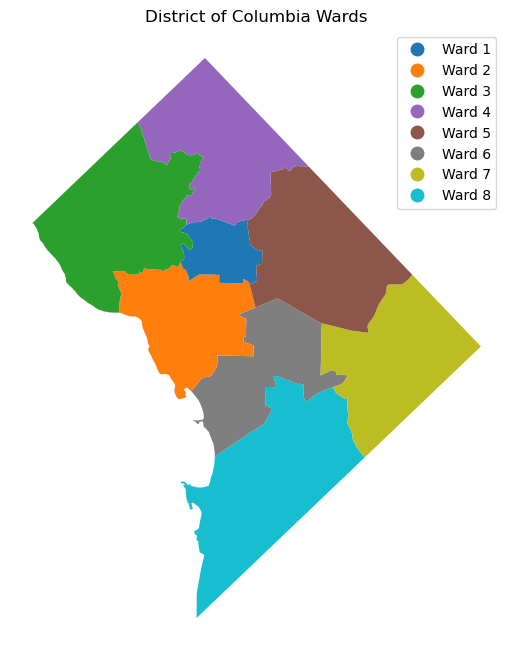

In [2]:
# Bring in the data and create simple plots

# Load the image data (original 8-band SuperDove imagery)
stack = os.path.join(projdir,'data/spatial/mod/dc_data/planet-data/dc_data_psscene8b.tif')
stack = rxr.open_rasterio(stack, cache=False, masked=True)
shp, gt, wkt, nd = stack.shape, stack.spatial_ref.GeoTransform, stack.rio.crs, stack.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Bands: {stack.band}; \n"
    f"Band Names: {stack.attrs['long_name']}; \n"
    f"Data Type: {stack[0].dtype}")

# # Create a map of the RGB
# fig, ax = plt.subplots(figsize=(6, 6))
# ep.plot_rgb(stack, rgb=(3, 2, 1), ax=ax)

# Geospatial data (DC wards)
wards = os.path.join(projdir,'data/spatial/raw/dc_data/boundaries/district_of_columbia_wards.gpkg')
wards = gpd.read_file(wards)
print(wards[["NAME","REP_NAME"]].head(8))

# Plot the DC wards
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
wards.plot(column='NAME', ax=ax, legend=True)
ax.set_title('District of Columbia Wards')
ax.set_axis_off()  # Removes the axis for a cleaner look
plt.show()


In [3]:
# Plot the abundance maps
print(list(class_codes))
ep.plot_bands(
    stack, title=list(class_codes), figsize=(8,8)
)

NameError: name 'class_codes' is not defined

In [8]:

import time
import traceback
from rasterstats import zonal_stats
import numpy as np

start_time = time.time()

print(class_codes)

all_band_stats = []  # Create a list to store all zonal statistics results
# Iterate over each band in the raster
for band in range(1, abundances.shape[0] + 1): # Bands are 1-indexed
    print(f"Band {band}")
    band_data = abundances.sel(band=band).astype(np.float32).fillna(np.nan).values
    stats = zonal_stats(footprints.geometry, band_data, affine=abundances.rio.transform(), stats="mean", nodata=abundances.rio.nodata)
    mean_values = [x['mean'] for x in stats]
    all_band_stats.append(mean_values)
    
    del band_data, stats, mean_values

# Add mean values for each band as a new column in the footprints dataframe
for i, band_mean_values in enumerate(all_band_stats, 1):
    footprints[f"band_{i}_mean"] = band_mean_values

print(f"Time elapsed: {round((time.time() - start_time)/60, 1)} minutes.") 

del all_band_stats


['ME' 'CS' 'SL' 'UR' 'WS' 'SH' 'TL']
Band 1
Band 2
Band 3
Band 4
Band 5
Band 6
Band 7
Time elapsed: 2.4 minutes.


['class_code' 'areaUTMsqft' 'uid' 'description' 'geometry' 'band_1_mean'
 'band_2_mean' 'band_3_mean' 'band_4_mean' 'band_5_mean' 'band_6_mean'
 'band_7_mean']
['ME' 'CS' 'SL' 'UR' 'WS' 'SH' 'TL']


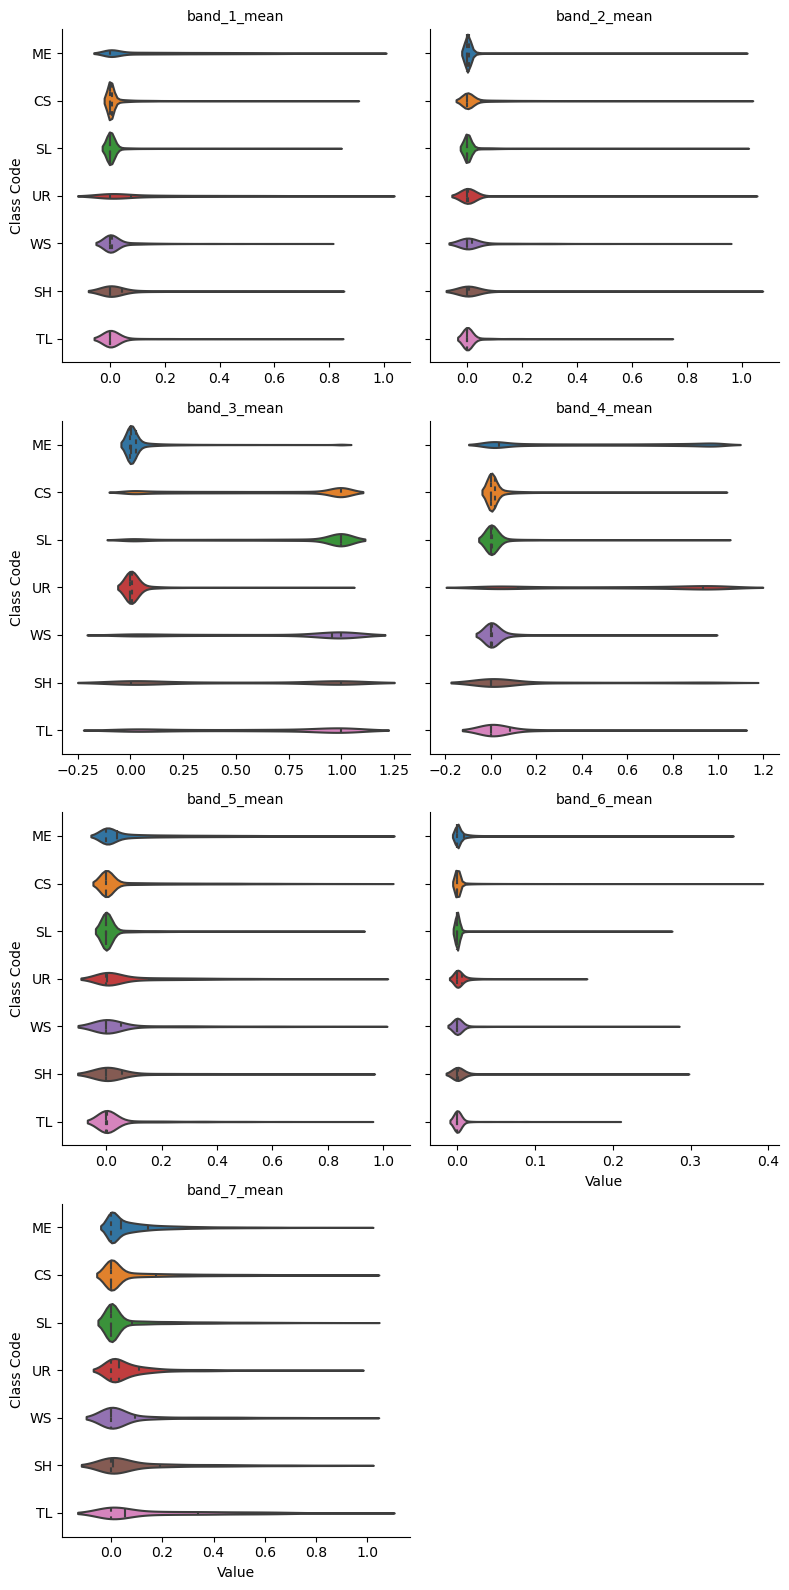

In [11]:

# Plot the distribution of abundances per material type by class

import seaborn as sns

print(footprints.columns.values)
print(class_codes)

# Melt the DataFrame to long format
footprints_m = footprints.melt(
    id_vars=['class_code'],
    value_vars=['band_1_mean','band_2_mean','band_3_mean','band_4_mean','band_5_mean','band_6_mean','band_7_mean'],
    var_name='Band',
    value_name='Value')
# Create a facet plot
g = sns.catplot(data=footprints_m, x='Value', y='class_code', col='Band',
                kind='violin', sharey=True, sharex=False, inner='quartile', col_wrap=2, height=4)
# Adjusting the titles and axis labels (if needed)
g.set_titles("{col_name}")
g.set_axis_labels("Value", "Class Code")
# Display the plot
plt.show()
